In [79]:
# PROCESS:
# STEP :1 :
# Download 50 images from the internet
# STEP :2 :
# Annotate via vgg Annotator
# STEP :3 :
# Download the COCO format json
#STEP:4 
# Explain Json File
# STEP  :5:
# Preprocess -Like normalising data, droping unnessary tables etc.
# STEP:6
# Find Optimal no of k using elbow method , apply mean IOU for all centroids.
# STEP :7:
# Plot the graph- find the number of clusters,and its centroids

In [80]:
#STEP:3
#Download Json from VGG Image Annotatator

#Annotation ->Export Annootation as Json 

# SAFETY_PROJECT_json.json

In [81]:
#STEP:4
#Explain JSON  File 

#The SAFETY_PROJECT_json is a JSON file with a number of key-value pairs. The root keys are some sort of image ids (which the VGG annotator generates) and the values are:

#filename: the name of the file with extension: like img1.jpg

#size: the size of the image, in bytes.

#regions: this is an array consisting of the bounding boxes

  #shape_attributes: 
    
    #name :how the bbox is defined, could be a circle, rectangle, etc. 
    #x:x cordinate of center of bounding box 
    #y:y cordinate of bounding box 
    #height :height of bounding box if it is a rectangle
    #width :width of bounding box if it is a rectangle

  #region_attributes:
    # this contained the label for the region, in this case, one of mask, hardhat, boots, vest, and some metadata which the dataset maker can add, like if the image is blurry, has good illumination, etc

  #file_attributes:
    #extra meta data of the image file, like the URL, caption and if it was from public domain, etc.




In [82]:
# STEP 5 :
  #PROCESSING THE JSON FILE 

In [83]:
import os
import json
import zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import KMeans

In [84]:
# pwd
# !cd 

In [85]:
dataset_path="/content/drive/MyDrive/EVA5B2/S12"
with open(os.path.join(dataset_path, "SAFETY_PROJECT_json.json")) as f:
    meta = json.load(f)


In [86]:

# looking at the first key-value pair in the metadata

image_key = list(meta.keys())[0]
img_meta = meta[image_key]
print(json.dumps({image_key: img_meta}, indent=2))

{
  "img1.jpg54876": {
    "filename": "img1.jpg",
    "size": 54876,
    "regions": [
      {
        "shape_attributes": {
          "name": "rect",
          "x": 255,
          "y": 27,
          "width": 282,
          "height": 181
        },
        "region_attributes": {
          "class_name": "hardhat"
        }
      },
      {
        "shape_attributes": {
          "name": "rect",
          "x": 325,
          "y": 238,
          "width": 176,
          "height": 161
        },
        "region_attributes": {
          "class_name": "mask"
        }
      }
    ],
    "file_attributes": {}
  }
}


In [87]:
# some helper functions

def get_bboxes(img_meta):
    """
    Gets the bounding box info from the metadata of the image.
    """
    bboxes = list()
    for bbox in img_meta["regions"]:
        shape_attrib = bbox["shape_attributes"]
        bboxes.append((
            shape_attrib["x"],
            shape_attrib["y"],
            shape_attrib["width"],
            shape_attrib["height"]
        ))
    return bboxes

def display_image(img_meta, figsize=(10, 15)):
    """
    Displays an image along with the bounding boxes.
    """
    bboxes = get_bboxes(img_meta)
    img_path = os.path.join(dataset_path, "images", img_meta["filename"])

    img = Image.open(img_path)
    fix, ax = plt.subplots(1, figsize=figsize)

    ax.imshow(img)

    for bbox in bboxes:
        x, y, width, height = bbox
        ax.add_patch(
            patches.Rectangle(
                (x, y),
                width,
                height,
                linewidth=3,
                edgecolor='r', 
                facecolor='none'
            )
        )
    
    plt.axis("off")
    plt.show()

def calc_bbox_ratios(img_meta):
    """
    Calculates the bbox_width:image_width and bbox_height:image_height ratios,
    given the metadata of an image.
    """
    ratios = []
    img_width, img_height = Image.open(
        os.path.join(dataset_path, "images", img_meta["filename"])
    ).size

    for bbox in get_bboxes(img_meta):
        x, y, width, height = bbox
        ratios.append((width / img_width, height / img_height))

    return ratios

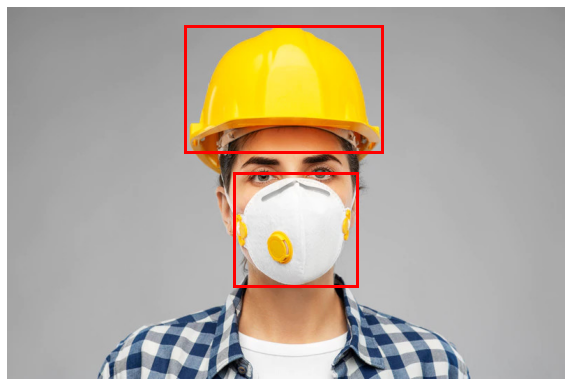

In [88]:
# displaying one of the images in the dataset
display_image(meta[image_key])

In [89]:
# calculating ratios for all images
bbox_ratios = []
for img_meta in meta.values():
    bbox_ratios.extend(calc_bbox_ratios(img_meta))
bbox_ratios = np.array(bbox_ratios)

In [90]:
bbox_ratios[0:10]

array([[0.3525    , 0.33958724],
       [0.22      , 0.30206379],
       [0.18714286, 0.16746411],
       [0.14428571, 0.16028708],
       [0.15714286, 0.17703349],
       [0.26571429, 0.38995215],
       [0.23285714, 0.43779904],
       [0.26714286, 0.49760766],
       [0.21375   , 0.29699248],
       [0.5325    , 0.56390977]])

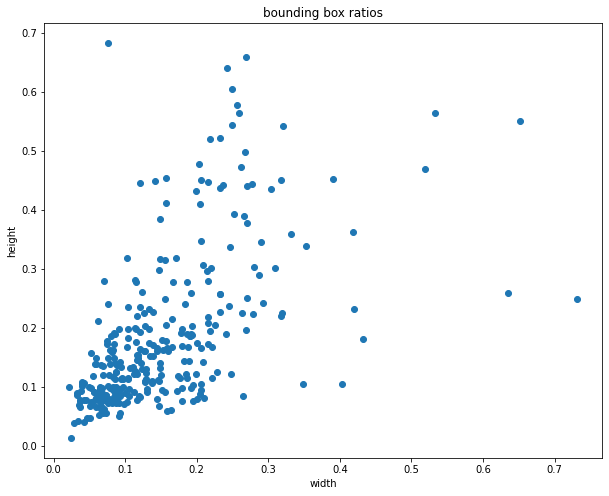

In [91]:
# plotting a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(bbox_ratios[:, 0], bbox_ratios[:, 1])
plt.xlabel("width")
plt.ylabel("height")
plt.title("bounding box ratios")
plt.show()

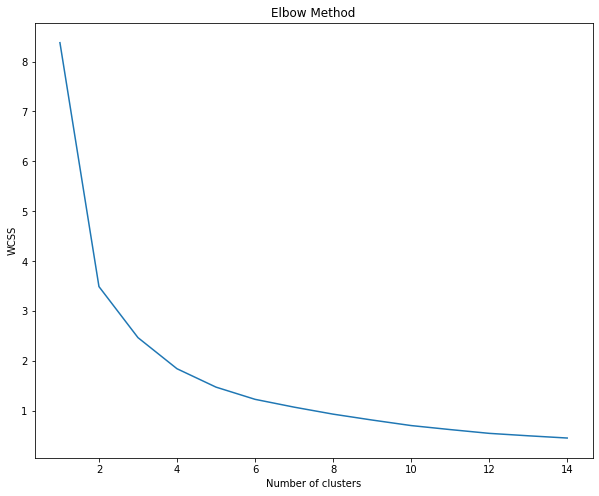

In [92]:
wcss = []
for c in range(1, 15):
    kmeans = KMeans(
        n_clusters=c,
        init='k-means++',
        max_iter=300,
        n_init=10,
        random_state=0
    )
    kmeans.fit(bbox_ratios)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [93]:
## PLOT K Means result 

Looks like an optimal number of clusters is 4. So lets plot it.

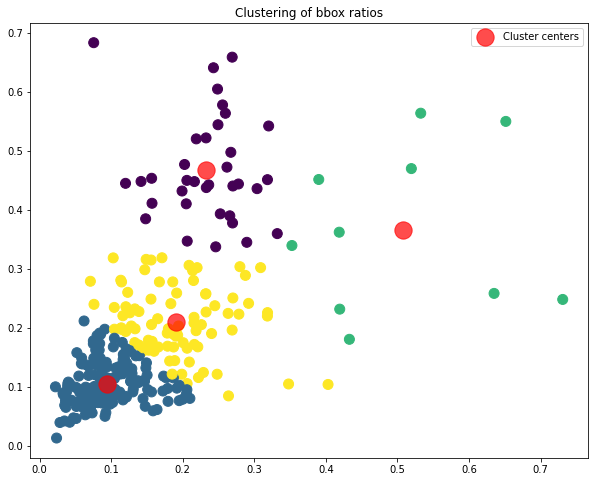

In [94]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(bbox_ratios)

plt.figure(figsize=(10, 8))
plt.scatter(bbox_ratios[:,0], bbox_ratios[:,1], c=pred_y, s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, alpha=.7, c='r', label="Cluster centers")
plt.title('Clustering of bbox ratios')
plt.legend()
plt.show()

In [95]:
# ANOTHER WAY FROM COCO JSON DATA 

In [96]:
import os
import json
import zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import KMeans
import pandas as pd 

In [97]:
dataset_path="/content/drive/MyDrive/EVA5B2/S12"
with open(os.path.join(dataset_path, "SAFETY_PROJECT_coco.json")) as f:
    data = json.load(f)


In [98]:
print(data.keys())
print('\n\n')
images = pd.DataFrame(data['images'], columns = data['images'][0].keys())
annotations = pd.DataFrame(data['annotations'], columns = data['annotations'][0].keys())


dict_keys(['info', 'images', 'annotations', 'licenses', 'categories'])





In [99]:

images.head()

,id,width,height,file_name,license,date_captured
0,1,800,533,img1.jpg,0,
1,2,700,418,img2.jpg,0,
2,3,800,532,img3.jpg,0,
3,4,800,533,img4.jpg,0,
4,5,840,560,img5.jpg,0,


In [100]:
annotations.head()

,segmentation,area,bbox,iscrowd,id,image_id,category_id
0,"[[255, 27, 537, 27, 537, 208, 255, 208]]",51042,"[255, 27, 282, 181]",0,1,1,1
1,"[[325, 238, 501, 238, 501, 399, 325, 399]]",28336,"[325, 238, 176, 161]",0,2,1,3
2,"[[42, 34, 173, 34, 173, 104, 42, 104]]",9170,"[42, 34, 131, 70]",0,3,2,1
3,"[[295, 42, 396, 42, 396, 109, 295, 109]]",6767,"[295, 42, 101, 67]",0,4,2,1
4,"[[446, 16, 556, 16, 556, 90, 446, 90]]",8140,"[446, 16, 110, 74]",0,5,2,1


# Preprocessing - Remove all unnecessary columns, spilt the bbox column

In [101]:
bbwidth = []
bbheight = []
bbx = []
bby = []
bbox = list(annotations['bbox'])
for i in bbox:
    bbx.append(i[0])
    bby.append(i[1])
    bbwidth.append(i[2])
    bbheight.append(i[3])
annotations['bbx'] = bbx
annotations['bby'] = bby
annotations['bbwidth'] = bbwidth
annotations['bbheight'] = bbheight
annotations = annotations.rename(columns={"image_id": "id"})
annotations = annotations.drop(["bbox","bbx","bby","id","segmentation","area","iscrowd"],axis =1)
annotations.head()

,category_id,bbwidth,bbheight
0,1,282,181
1,3,176,161
2,1,131,70
3,1,101,67
4,1,110,74


In [102]:
images = images.drop(["license","date_captured"],axis = 1)
images.head()

,id,width,height,file_name
0,1,800,533,img1.jpg
1,2,700,418,img2.jpg
2,3,800,532,img3.jpg
3,4,800,533,img4.jpg
4,5,840,560,img5.jpg


In [103]:

finalfile = pd.concat([images,annotations],axis = 1)
finalfile = finalfile.drop(["id"],axis =1)
finalfile.head()

,width,height,file_name,category_id,bbwidth,bbheight
0,800.0,533.0,img1.jpg,1,282,181
1,700.0,418.0,img2.jpg,3,176,161
2,800.0,532.0,img3.jpg,1,131,70
3,800.0,533.0,img4.jpg,1,101,67
4,840.0,560.0,img5.jpg,1,110,74


# NORMALIZE THE DATA 

In [104]:

finalfile['bbwidth'] = finalfile['bbwidth'].div(finalfile['width'])
finalfile['bbheight'] = finalfile['bbheight'].div(finalfile['height'])
finalfile['height'] = finalfile['height'].div(finalfile['height'])
finalfile['width'] = finalfile['width'].div(finalfile['width'])

finalfile.head()

,width,height,file_name,category_id,bbwidth,bbheight
0,1.0,1.0,img1.jpg,1,0.352500,0.339587
1,1.0,1.0,img2.jpg,3,0.251429,0.385167
2,1.0,1.0,img3.jpg,1,0.163750,0.131579
3,1.0,1.0,img4.jpg,1,0.126250,0.125704
4,1.0,1.0,img5.jpg,1,0.130952,0.132143


In [105]:
# Drop unnecssary column 

In [109]:
table_for_algo = finalfile.drop(["width","height","file_name","category_id"],axis = 1)
print(len(table_for_algo))
table_for_algo.head()

309


,bbwidth,bbheight
0,0.352500,0.339587
1,0.251429,0.385167
2,0.163750,0.131579
3,0.126250,0.125704
4,0.130952,0.132143


In [110]:
table_for_algo.describe()

,bbwidth,bbheight
count,70.000000,70.000000
mean,0.116692,0.151158
std,0.106819,0.164398
min,0.012222,0.007812
25%,0.031571,0.043450
50%,0.093296,0.076184
75%,0.144835,0.162927
max,0.486911,0.709163


In [111]:
table_for_algo =table_for_algo.reset_index()
len(table_for_algo)

309

In [112]:
import pandas as pd

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
table_for_algo=clean_dataset(table_for_algo)

In [113]:
len(table_for_algo)

70

In [20]:
#visualize the data 

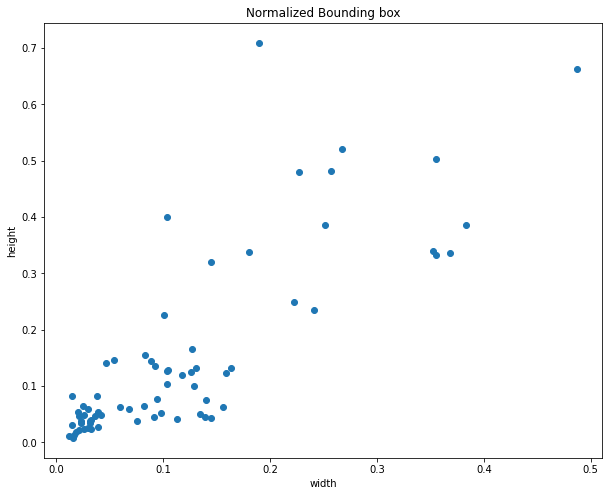

In [114]:
# plotting a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(table_for_algo['bbwidth'],table_for_algo['bbheight'])
plt.xlabel("width")
plt.ylabel("height")
plt.title("Normalized Bounding box")
plt.show()

In [23]:
#USE K Means clustering to find optimal cluster 

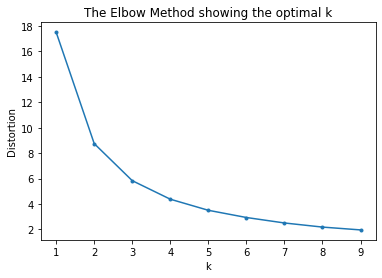

In [115]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt



# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(table_for_algo)
    kmeanModel.fit(table_for_algo)
    distortions.append(sum(np.min(cdist(table_for_algo, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) /table_for_algo.shape[0])

# Plot the elbow
plt.plot(K, distortions, '.-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

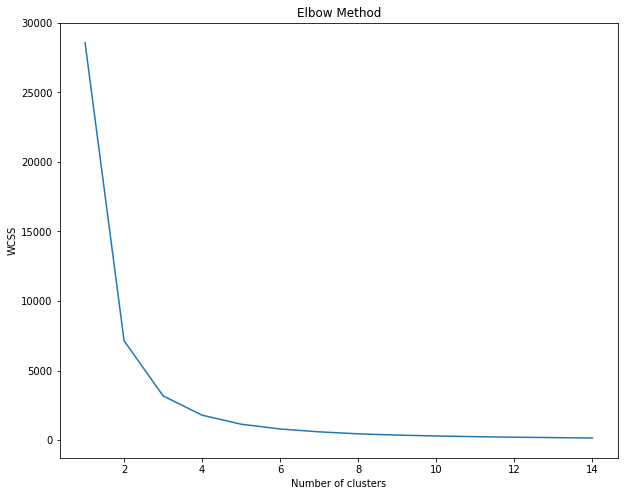

In [116]:
wcss = []
for c in range(1, 15):
    kmeans = KMeans(
        n_clusters=c,
        init='k-means++',
        max_iter=300,
        n_init=10,
        random_state=0
    )
    kmeans.fit(table_for_algo)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Iou Method to find out K

## IOU(Intersection over union) = intersected area of bbox and anchor box/ Union area of bbox and anchor box

### bw = bounding box width
### bh = bounding box height
### aw = anchor box width
### ah = anchor box height

### IOU = min(bw,aw) min(bh, ah)/bwbh + awah - min(bw,aw) min(bh, ah)

### mean IOU = sum(IOU)/len(IOU)

In [117]:
#Basically we need 2 things to calculate IOU 

#1. anchor box 
#2. bounding box 

# We have bounding box H, W 
# Anchor box can be centroid of cluster 
# meaning first iteration anchor box is 1 i.e centroid of each data point 
# in 2nd iteration anchor box is 2 nos , we will get h1,w1 i.e anchor box 1 h2,w2 i.e anchor box 2 
                                        #calculate IOU for anchor box1 with all points 
                                        #alculate IOU with anchor box2 with all points 

In [120]:

height = list(table_for_algo['bbheight'])
width = list(table_for_algo['bbwidth'])
ks = range(1,10)
meaniou = []
for k in ks:
    cl = KMeans(n_clusters=k)
    cl.fit(table_for_algo)
    cx = []
    cy = []
    mapcx  = {}
    mapcy = {}
    iou = []
    for i in range(70):
        
        l = cl.labels_[i]
        cx.append(cl.cluster_centers_[l][0])
        cy.append(cl.cluster_centers_[l][1])
        iou.append(min(width[i] ,cx[i])* min(height[i] , cy[i])/(height[i]*width[i]+ cx[i]*cy[i]- min(width[i] , cx[i])* min(height[i] ,cy[i])))
    meaniou.append(sum(iou)/70)

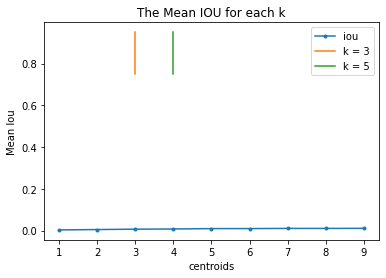

In [121]:

plt.plot(range(1,10),meaniou,'.-',label = "iou")
plt.plot([3,3],[0.75,0.95],label = "k = 3")
plt.plot([4,4],[0.75,0.95],label = "k = 5")
plt.xlabel('centroids')
plt.ylabel('Mean Iou')
plt.title('The Mean IOU for each k')
plt.legend()
plt.show()